In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sn
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Flatten, Dropout, Activation, Conv2D, MaxPooling2D, LeakyReLU
from tensorflow.keras.callbacks import TensorBoard
from PIL import Image
import time
from PIL import Image
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.preprocessing import image, image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import cv2
from tensorflow import keras

# from sklearn.model_selection import KFold

start = time.time()

In [2]:
dim = (176,176)               # input image dimensions                                              (176,208)
test_split_percent = .1       # % of total data for testing                                         .1
validation_split_percent = .2 # % of total data for validation                                      .2
zoom = [.99,1.01]             # zoom range (for a fixed zoom put the same value in both parameters)[.99,1.01]
bright_range = [.8,1.2]       # brightness range                                                    [.8,1.2] 
layers_unlocked = True        # unlock the imported pre-training layers?                            False  
lr = 0.0001                   # learning rate for optimizer                                         0.0001
batch = 16                   # batch size for model fitting                                        20
eps = 5                      # number of epochs to run                                             50
momentum = .9                 # momentum of SGD                                                     .9

In [3]:
train_dr = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,fill_mode='constant',cval=0,
brightness_range=bright_range,zoom_range=zoom, data_format='channels_last',zca_whitening=False)

train_data_gen = train_dr.flow_from_directory(directory="./data2/train/",target_size=dim,batch_size=5000)

# Change to zoom = [1,1] to use normal test data
test_dr = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,fill_mode='constant',cval=0,zoom_range=[1,1],data_format='channels_last') 
test_data_gen = test_dr.flow_from_directory(directory="./data2/test/",target_size=dim,batch_size=5000,
                                           shuffle = False)

Found 8582 images belonging to 4 classes.
Found 1707 images belonging to 4 classes.


In [4]:
train_data,train_labels =  train_data_gen.next()
test_data,test_labels = test_data_gen.next()
total_data = np.concatenate((train_data,test_data))
total_labels = np.concatenate((train_labels,test_labels))
print(total_data.shape)
print(total_labels.shape)

(6707, 176, 176, 3)
(6707, 4)


In [5]:
initial_split = test_split_percent+validation_split_percent
test_val_split = test_split_percent/initial_split

# split into training and (test + validation)
train_data, test_val_data, train_labels, test_val_labels = train_test_split(total_data,total_labels,
                                                                            test_size=initial_split)

# split (test + validation) into test and validation sets
test_data, val_data, test_labels, val_labels = train_test_split(test_val_data,test_val_labels,
                                                                test_size=test_val_split)

print('train: ',train_data.shape)
print('validation',val_data.shape)
print('test',test_data.shape)

train:  (4694, 176, 176, 3)
validation (671, 176, 176, 3)
test (1342, 176, 176, 3)


In [6]:
print(train_data.shape)
print(train_labels.shape)
print(val_data.shape)
print(val_labels.shape)
print(test_data.shape)
print(test_labels.shape)

(4694, 176, 176, 3)
(4694, 4)
(671, 176, 176, 3)
(671, 4)
(1342, 176, 176, 3)
(1342, 4)


In [7]:
image_generator = ImageDataGenerator(rescale=1/255, validation_split=0.2) #shear_range =.25, zoom_range =.2, horizontal_flip = True, rotation_range=20)     


train_dataset = image_generator.flow_from_directory(batch_size=8,
                                                 directory='./data2/train/',
                                                 shuffle=True,
                                                 target_size=(176,208), 
                                                 subset="training",
                                                 class_mode='categorical')

validation_dataset = image_generator.flow_from_directory(batch_size=8,
                                                 directory='./data2/train/',
                                                 shuffle=True,
                                                 target_size=(176,208), 
                                                 subset="validation",
                                                 class_mode='categorical')

image_generator_submission = ImageDataGenerator(rescale=1/255) 
submission = image_generator_submission.flow_from_directory(
                                                 directory='./data2/test/',
                                                 shuffle=False,
                                                 target_size=(176,208), 
                                                 class_mode=None)

Found 6867 images belonging to 4 classes.
Found 1715 images belonging to 4 classes.
Found 1707 images belonging to 4 classes.


c:\Users\Jaswanth\AppData\Local\Programs\Python\Python310\lib\site-packages\matplotlib\text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


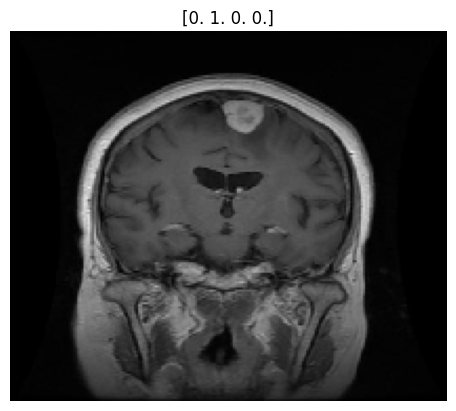

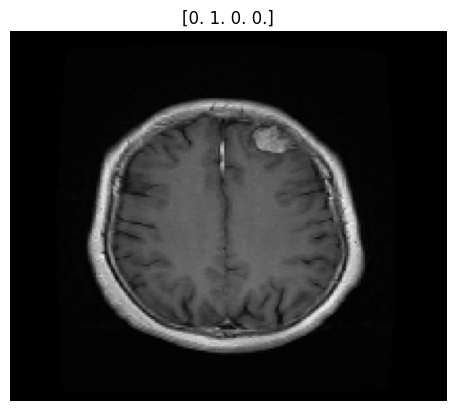

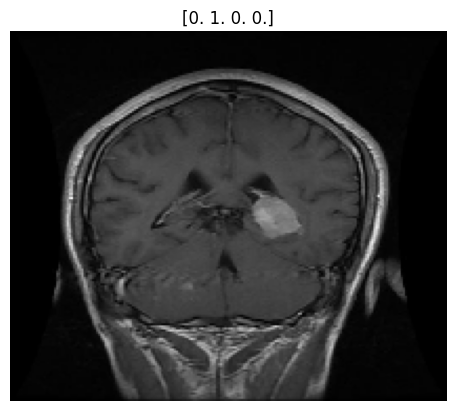

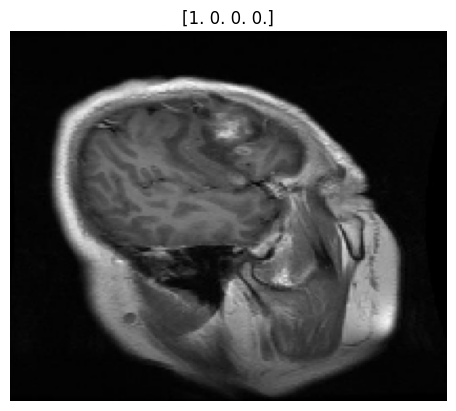

In [8]:
batch_1_img = train_dataset[0]
for i in range(0,4):
    img = batch_1_img[0][i]
    lab = batch_1_img[1][i]
    plt.imshow(img)
    plt.title(lab)
    plt.axis('off')
    plt.show()

In [9]:
vgg = VGG19(input_shape=(176,208,3), weights='imagenet', include_top=False)
for layer in vgg.layers:
    layer.trainable = False
x = Flatten()(vgg.output)
# x = Dropout(0.5)(x) #remove this if accuracy reduces its useless
prediction = Dense(4, activation='softmax')(x)

modelvgg = Model(inputs=vgg.input, outputs=prediction)
modelvgg.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 176, 208, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 176, 208, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 176, 208, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 88, 104, 64)       0         
                                                                 
 block2_conv1 (Conv2D)       (None, 88, 104, 128)      73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 88, 104, 128)      147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 44, 52, 128)       0     

In [10]:
modelvgg.compile(optimizer='adam',
loss=tf.losses.CategoricalCrossentropy(),
metrics=[keras.metrics.AUC(name='auc')])

In [11]:
model1 = modelvgg.fit(train_dataset, epochs=10, validation_data=validation_dataset) #high epoch high validation loss

Epoch 1/10
859/859 [==============================] - 1507s 2s/step - loss: 0.4663 - auc: 0.9631 - val_loss: 0.2586 - val_auc: 0.9875
Epoch 2/10
859/859 [==============================] - 1441s 2s/step - loss: 0.2671 - auc: 0.9862 - val_loss: 0.2044 - val_auc: 0.9922
Epoch 3/10
859/859 [==============================] - 1560s 2s/step - loss: 0.1948 - auc: 0.9921 - val_loss: 0.1632 - val_auc: 0.9942
Epoch 4/10
859/859 [==============================] - 617s 719ms/step - loss: 0.1299 - auc: 0.9962 - val_loss: 0.0806 - val_auc: 0.9989
Epoch 5/10
859/859 [==============================] - 609s 709ms/step - loss: 0.1190 - auc: 0.9969 - val_loss: 0.5352 - val_auc: 0.9662
Epoch 6/10
859/859 [==============================] - 619s 720ms/step - loss: 0.1020 - auc: 0.9976 - val_loss: 0.0403 - val_auc: 0.9997
Epoch 7/10
859/859 [==============================] - 1025s 1s/step - loss: 0.0815 - auc: 0.9984 - val_loss: 0.2318 - val_auc: 0.9912
Epoch 8/10
859/859 [==============================] - 12

In [12]:
loss, accuracy = modelvgg.evaluate(validation_dataset)
print("Loss: ", loss)
print("Accuracy: ", accuracy)

215/215 [==============================] - 111s 515ms/step - loss: 0.0563 - auc: 0.9988
Loss:  0.05630144849419594
Accuracy:  0.9987502098083496


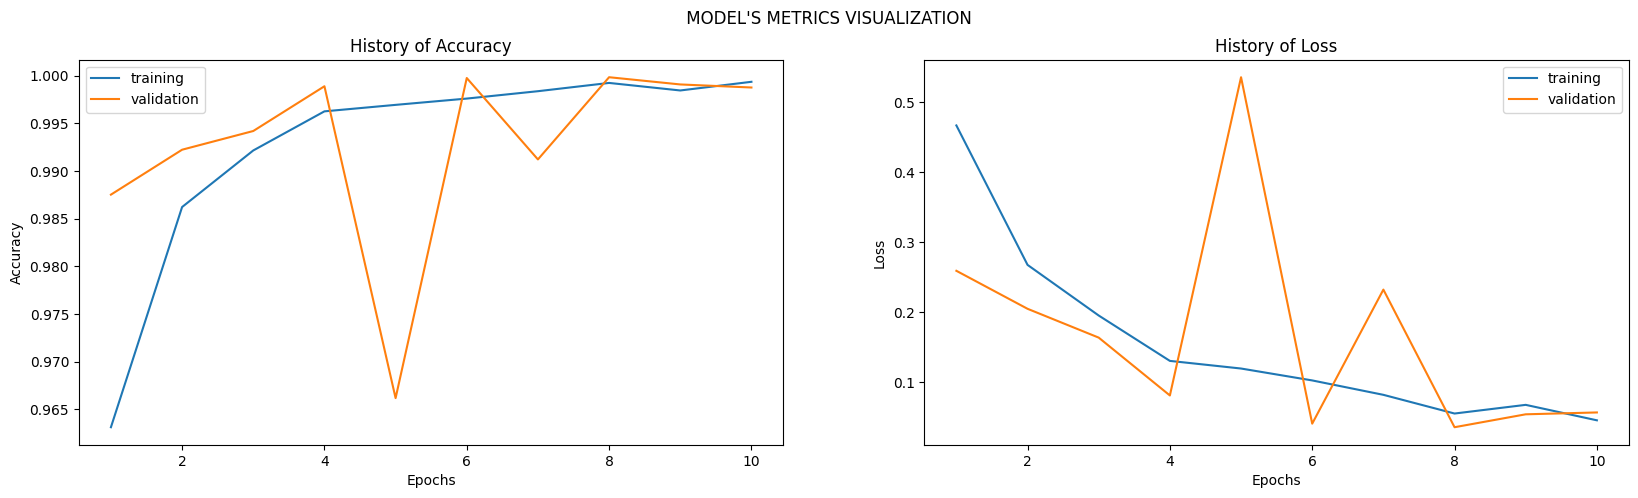

In [13]:
def Train_Val_Plot(acc,val_acc,loss,val_loss):
    
    fig, (ax1, ax2) = plt.subplots(1,2, figsize= (20,5))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])
    plt.show()
    

Train_Val_Plot(model1.history['auc'],model1.history['val_auc'],
               model1.history['loss'],model1.history['val_loss'])

In [14]:
modelvgg.save('VGG_MODEL_F.h5')


c:\Users\Jaswanth\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [18]:
ci=['glioma','meningioma','no-tumor','pituitary']
# Load the image
image = cv2.imread('./testim1.jpg')

# Resize the image to match the expected input shape
image = cv2.resize(image, (208, 176))

# Normalize the image
image = image / 255.0

# Add an extra dimension to the image
image = np.expand_dims(image, axis=0)

# Load the model
model = keras.models.load_model('./VGG_MODEL_F.h5')

# Predict the class probabilities of the image
prediction = model.predict(image)

# Get the index of the class with the highest probability
pci = np.argmax(prediction[0])

# Display the result
print(prediction[0])
print('The predicted class index is:', ci[pci])


1/1 [==============================] - 0s 156ms/step
[3.3661631e-06 8.1216238e-02 6.0773200e-09 9.1878039e-01]
The predicted class index is: pituitary
